In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
batch_size=256
learning_rate=0.001
epochs=30

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_train, fmnist_val=torch.utils.data.random_split(fmnist_train, [50000, 10000])

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [4]:
dataloader=dict()
dataloader["train"]=DataLoader(fmnist_train, batch_size, shuffle=True)
dataloader["val"]=DataLoader(fmnist_val, batch_size, shuffle=False)
dataloader["test"]=DataLoader(fmnist_test, batch_size, shuffle=False)

In [13]:
class ResBlock(nn.Module):
  def __init__(self, in_channel, out_channel, stride=1, down_sample=False):
    super(ResBlock, self).__init__()
    self.layer1=nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
        nn.ReLU()
    )
    self.layer2=nn.Sequential(
        nn.Conv2d(out_channel, out_channel, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channel),
    )
    self.relu=nn.ReLU()
    self.in_channel=in_channel
    self.out_channel=out_channel
    self.stride=stride
    self.down_sample=down_sample

  def down_sampling(self, x):
    out=F.pad(x,(0,0,0,0,0,self.out_channel-self.in_channel))
    out=nn.MaxPool2d(2, stride=self.stride)(out)
    return out

  def forward(self, x):
    shortcut=x

    out=self.layer1(x)
    if self.down_sample==True:
      shortcut=self.down_sampling(x)
    out=self.layer2(out)
    out+=shortcut
    out=self.relu(out)
    return out

In [14]:
class ResNet(nn.Module):
  def __init__(self, num_layers, block):
    super(ResNet, self).__init__()
        
    self.num_layers=num_layers
    self.layer1=nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True)
    )
    self.resblock1=self.get_layers(block, 16, 16, stride=1) #16*28*28
    self.resblock2=self.get_layers(block, 16, 32, stride=2) #32*14*14
    self.resblock3=self.get_layers(block, 32, 64, stride=2) #64*7*7


    self.avgpool=nn.AvgPool2d(7, stride=1)
    self.fc=nn.Linear(64, 10)

  def get_layers(self, block, in_channel, out_channel, stride):
    if stride==1:
      down_sample=False
    else:
      down_sample=True
      
    layer_list = nn.ModuleList([block(in_channel, out_channel, stride, down_sample)])
    for _ in range(self.num_layers - 1):
      layer_list.append(block(out_channel, out_channel))
    return nn.Sequential(*layer_list)

  def forward(self, x):
    out=self.layer1(x)
    out=self.resblock1(out)
    out=self.resblock2(out)
    out=self.resblock3(out)
    out=self.avgpool(out)
    out=out.view(out.size(0),-1)
    out=self.fc(out)
    return out

In [15]:
block=ResBlock
model=ResNet(2, block).to(device)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [17]:
best_model=copy.deepcopy(model.state_dict())
best_eval_loss=float('inf')
train_history=[]
eval_history=[]
for epoch in range(epochs):
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
    running_loss = 0.0
    for x,y in dataloader[phase]:
      x=x.to(device)
      y=y.to(device)
      optimizer.zero_grad()

      with torch.set_grad_enabled(phase=='train'):
        output=model(x)
        loss=criterion(output,y)
        if phase=='train':
          loss.backward()
          optimizer.step()
      running_loss+=loss.item()
      epoch_loss = running_loss / len(dataloader[phase].dataset)

    if phase=='train':
      print(f'Epoch {epoch}/{epochs-1}')
      print(f'train loss: {epoch_loss}')
      train_history.append(epoch_loss)
    else:
      print(f'eval loss: {epoch_loss}')
      eval_history.append(epoch_loss)
      if epoch_loss<best_eval_loss:
        best_eval_loss=epoch_loss
        best_model=copy.deepcopy(model.state_dict())

print(f'Best Validation Loss: {best_eval_loss}')

Epoch 0/29
train loss: 0.0021866367876529694
eval loss: 0.0024715268313884736
Epoch 1/29
train loss: 0.0012191763907670975
eval loss: 0.0017654739886522294
Epoch 2/29
train loss: 0.0010040221378207206
eval loss: 0.0012361492857336997
Epoch 3/29
train loss: 0.0008934839969873429
eval loss: 0.001005056070908904
Epoch 4/29
train loss: 0.0007947774922847748
eval loss: 0.001312308632582426
Epoch 5/29
train loss: 0.0007271548652648925
eval loss: 0.0010388051368296145
Epoch 6/29
train loss: 0.0006619560730457306
eval loss: 0.0010746479824185371
Epoch 7/29
train loss: 0.0006035053919255733
eval loss: 0.0014305951364338397
Epoch 8/29
train loss: 0.0005541745428740978
eval loss: 0.00092566152587533
Epoch 9/29
train loss: 0.0005144638882577419
eval loss: 0.0010712064821273089
Epoch 10/29
train loss: 0.00047184151932597163
eval loss: 0.001257691221497953
Epoch 11/29
train loss: 0.0004088508336991072
eval loss: 0.0011742540940642358
Epoch 12/29
train loss: 0.0003796394804120064
eval loss: 0.0012021

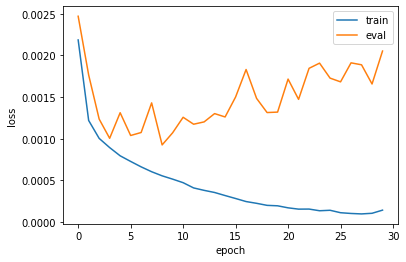

In [18]:
plt.plot(train_history, label="train")
plt.plot(eval_history, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

In [20]:
model.load_state_dict(best_model)
total=0
correct=0
with torch.no_grad():
  for x,y in dataloader['test']:
    x=x.to(device)
    y=y.to(device)
    output=model(x)
    _,pred=torch.max(output.data,1)
    total+=y.size(0)
    correct+=(pred==y).sum().item()

print(f'Accuracy: {100*correct/total}')

Accuracy: 91.65
